## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
import heapq

from graphviz import Digraph

## Defining the base classes for the tree

In [2]:
class Node:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        # self.split_feature = None
        # self.split_value = None

    def __sub__(self, other):
        return np.sum((self.value - other.value)**2) **0.5
    
class SplitNode:
    def __init__(self, split_feature, split_value):
        self.split_value = split_value
        self.split_feature = split_feature
        self.left = None
        self.right = None

## Methods for building and visualising the tree 

In [3]:
def build_tree(datapoints, feature_queue = None):
    n = datapoints.shape[0]

    if feature_queue is None:
        feature_queue = deque(range(datapoints.shape[1]))

    # Base cases
    if n == 0:
        return None
    if n == 1:
        return Node(datapoints[0])

    # Cycling through the feature
    local_feature_queue = deque(feature_queue)
    feature_to_split_on = local_feature_queue.popleft()
    local_feature_queue.append(feature_to_split_on)

    # Performing the split
    sorted_datapoints = datapoints[datapoints[:, feature_to_split_on].argsort()]
    median_index = len(sorted_datapoints) // 2
    split_value = sorted_datapoints[median_index, feature_to_split_on]
    root_node = SplitNode(feature_to_split_on, split_value)
    left_datapoints = sorted_datapoints[sorted_datapoints[:, feature_to_split_on] < split_value]
    right_datapoints = sorted_datapoints[sorted_datapoints[:, feature_to_split_on] >= split_value]

    # Avoids infinite recursion
    if len(left_datapoints) == n or len(right_datapoints) == n:
        left_datapoints = sorted_datapoints[:median_index]
        right_datapoints = sorted_datapoints[median_index:]

    # Subtrees
    root_node.left = build_tree(left_datapoints, local_feature_queue)
    root_node.right = build_tree(right_datapoints, local_feature_queue)

    return root_node

In [4]:
def visualize_tree(root_node):
    """Plots the KD Tree"""
    def add_nodes_edges(graph, node, parent_id=None, child_label=""):
        if node is not None:
            node_id = str(id(node))

            # Decision nodes
            if isinstance(node, SplitNode):
                label = f"Split feature -->{node.split_feature}, value -->  {node.split_value}"
                graph.node(node_id, label = label, shape='ellipse', style='filled', fillcolor='lightblue')

            # Leaf nodes
            elif isinstance(node, Node):
                label = f"Point: {node.value}"
                graph.node(node_id, label=label, shape='box', style='filled', fillcolor='lightgreen')

            # Setting up upward connections
            if parent_id is not None:
                graph.edge(parent_id, node_id, label=child_label)

            # Building the left and right sub-trees
            add_nodes_edges(graph, node.left, node_id, "Left")
            add_nodes_edges(graph, node.right, node_id, "Right")

    dot = Digraph()
    add_nodes_edges(dot, root_node)
    dot.render('kd_tree', format='png', view=True)
    return 

In [5]:
# Testing the implementations till now
datapoints = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [10, 11]])
root_node = build_tree(datapoints)
visualize_tree(root_node)

## Building the KD Class for KNN

In [6]:
class KDTree:
    def __init__(self):
        self.tree = None
        self.heap = []

    def fit(self, datapoints):
        """This method builds the KD-tree"""
        print(datapoints.shape)
        self.tree = build_tree(datapoints)

    def show_tree(self):
        """This method can be used for visualising the result"""
        if self.tree is None:
            raise ValueError("Call the fit method before trying to view the tree!")
        
        dot = visualize_tree(self.tree)
        dot.format = 'png'
        dot.render(view=True)
        visualize_tree(self.tree)
        return
    
    def predict(self, datapoint, k = 1, nature = "approx"):
        """Method to predict the k nearest neighbors to a given point"""

        if self.tree is None:
            raise ValueError("Call the fit method before using predict!")
        
        # Max-heap of size k
        self.heap = []
        
        def search_knn(node, datapoint, depth=0):
            if node is None:
                return
            
            # Leaf Node
            if isinstance(node, Node):
                dist = np.linalg.norm(datapoint - node.value)
                
                
                if len(self.heap) < k:
                    heapq.heappush(self.heap, (-dist, node.value.tolist()))
                else:
                    if dist < -self.heap[0][0]:
                        heapq.heappushpop(self.heap, (-dist, node.value.tolist()))
                return
            
            # Decision node
            elif isinstance(node, SplitNode):
                feature_index = node.split_feature
                split_value = node.split_value
                
                # Determine near and far branches
                if datapoint[feature_index] < split_value:
                    near_branch = node.left
                    far_branch = node.right
                else:
                    near_branch = node.right
                    far_branch = node.left
                
                # Search the near branch first
                search_knn(near_branch, datapoint, depth + 1)
                
                # This occurs if there is potential for closer neighbors in the far branch
                if nature == "exact":
                    if len(self.heap) < k or abs(split_value - datapoint[feature_index]) < -self.heap[0][0]:
                        search_knn(far_branch, datapoint, depth + 1)
                
                elif nature == "approx":
                    if len(self.heap) < k:
                        search_knn(far_branch, datapoint, depth + 1)
        
        # Start the traversal
        search_knn(self.tree, datapoint)
 
        # Return the k nearest neighbors
        neighbors = np.array([neighbor for _, neighbor in sorted(self.heap, reverse=True)])
        return neighbors

In [7]:
def visualize_prediction(query_point, datapoints, k):
    # Create an instance of the KDTree and fit the data
    kd_tree = KDTree()
    kd_tree.fit(datapoints)
    k_neighbors = kd_tree.predict(query_point, k)

    # Plot the data for visualisation
    plt.scatter(datapoints[: , 0], datapoints[: , 1], color = 'blue', label = "Given data")
    query_point = query_point.reshape(-1, 1)
    plt.scatter(k_neighbors[:, 0], k_neighbors[:, 1], color = 'orange', label = "Nearest neighbours")
    plt.scatter(query_point[0], query_point[1], color = 'red', label = "Query point")
    plt.grid(True)
    plt.title("KNN visualisation")
    plt.show()
    return

In [8]:
# Sample usage

datapoints = np.array([[1, 1],
                       [0, 0],
                       [0, 0.5],
                       [2, 2]])

kd_tree = KDTree()
kd_tree.fit(datapoints)
kd_tree.predict(np.array([0.5, 0.5]), 2)

(4, 2)


array([[0. , 0.5],
       [0. , 0. ]])

## Displaying its usage

In [9]:
# Random datapoint selection
num_points = 200
num_features = 2

datapoints = np.random.randint(0, 150, size = (num_points, num_features))

In [10]:
# Visualising the tree
root_node = build_tree(datapoints)
visualize_tree(root_node)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.950595 to fit


(200, 2)


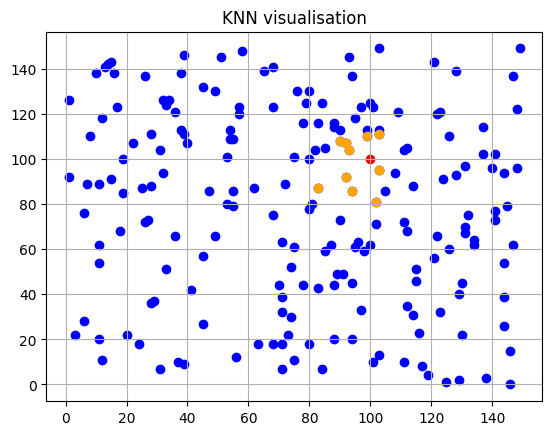

In [10]:
# Visualising the KNN results
visualize_prediction(query_point = np.array([100, 100]), datapoints = datapoints, k = 10)

(200, 2)


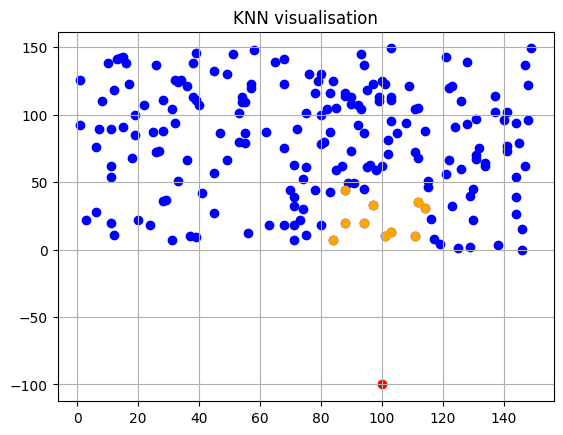

In [11]:
# Result to display the approzimate nature of this method
visualize_prediction(query_point = np.array([100,  -100]), datapoints = datapoints, k = 10)

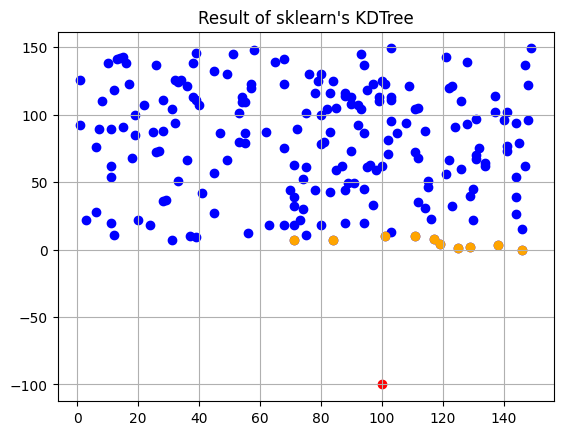

In [12]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 10, algorithm = 'kd_tree')
neigh.fit(datapoints)
ans = neigh.kneighbors(np.array([[100, -100]]))

plt.scatter(datapoints[:, 0], datapoints[:, 1], color = "blue")
plt.scatter(datapoints[ans[1], 0], datapoints[ans[1], 1], color = "orange")
plt.scatter(100, -100, color = "red")
plt.title("Result of sklearn's KDTree")
plt.grid(True)
plt.show()